In [162]:
# 1. 라이브러리 불러오기
import pandas as pd

# 2. 파일 경로 설정 (data 폴더 기준)
unemployment_file = "./data/성_연령별_실업자.xlsx"
marriage_file = "./data/혼인_건수.csv"

# 3. 실업자 수 데이터 불러오기 및 전처리
unemp_df = pd.read_excel(unemployment_file, sheet_name='데이터')
unemp_df['성별'].fillna(method='ffill', inplace=True)

# 사용할 연령/성별 조합
ages = ['20 - 29세', '30 - 39세']
sexes = ['남자', '여자']

# 연도 컬럼만 필터링
year_cols = [col for col in unemp_df.columns if isinstance(col, str) and col.startswith('20')]
year_cols = [col for col in year_cols if 2001.0 <= float(col) <= 2022.06]

# 성별+연령 조합별 평균 실업자 수 계산
unemp_result = []
for gender in sexes:
    for age in ages:
        subset = unemp_df[(unemp_df['성별'] == gender) & (unemp_df['연령계층별'] == age)]
        if not subset.empty:
            mean_series = subset[year_cols].T.mean(axis=1)
            mean_series.index = pd.to_datetime(mean_series.index).year
            mean_series = mean_series.groupby(mean_series.index).mean()
            df_temp = pd.DataFrame({
                '연도': mean_series.index,
                '연령대': '20대' if '20' in age else '30대',
                '성별': gender,
                '값': mean_series.values * 1000,  # 천명 → 명
                '지표': '실업자 수'
            })
            unemp_result.append(df_temp)

unemployment_final = pd.concat(unemp_result, ignore_index=True)

# 4. 혼인 건수 데이터 불러오기 및 전처리
marriage_df = pd.read_csv(marriage_file)

def get_age_group(age_str):
    try:
        age = int(age_str.replace("세", ""))
        if 20 <= age <= 29:
            return '20대'
        elif 30 <= age <= 39:
            return '30대'
    except:
        return None

marriage_df['아내_연령대'] = marriage_df['아내의 연령별'].apply(get_age_group)
marriage_df['남편_연령대'] = marriage_df['남편의 연령별'].apply(get_age_group)
year_columns = [col for col in marriage_df.columns if '년' in col]
clean_year_columns = [int(col.replace(" 년", "")) for col in year_columns]

# 아내 기준
female = marriage_df[marriage_df['아내_연령대'].isin(['20대', '30대'])]
female_grouped = female.groupby('아내_연령대')[year_columns].sum().T
female_grouped['연도'] = clean_year_columns
female_grouped = female_grouped.melt(id_vars='연도', var_name='연령대', value_name='값')
female_grouped['성별'] = '여자'
female_grouped['지표'] = '혼인 건수'

# 남편 기준
male = marriage_df[marriage_df['남편_연령대'].isin(['20대', '30대'])]
male_grouped = male.groupby('남편_연령대')[year_columns].sum().T
male_grouped['연도'] = clean_year_columns
male_grouped = male_grouped.melt(id_vars='연도', var_name='연령대', value_name='값')
male_grouped['성별'] = '남자'
male_grouped['지표'] = '혼인 건수'

# 혼인 데이터 합치기
marriage_final = pd.concat([female_grouped, male_grouped], ignore_index=True)

# 5. 실업자 + 혼인 건수 통합
final_df = pd.concat([unemployment_final, marriage_final], ignore_index=True)

# 6. 연도 2001~2022년 누락 방지 - 모든 조합 채우기
full_years = list(range(2001, 2023))
age_groups = ['20대', '30대']
sexes = ['남자', '여자']
kinds = ['실업자 수', '혼인 건수']

from itertools import product
full_index = pd.DataFrame(product(full_years, age_groups, sexes, kinds), columns=['연도', '연령대', '성별', '지표'])

# 누락된 조합 보완
final_df = pd.merge(full_index, final_df, how='left', on=['연도', '연령대', '성별', '지표'])
final_df['값'] = final_df['값'].fillna(0)  # 누락 데이터는 0으로 처리

# 7. 결과 미리보기
final_df = final_df.sort_values(by=['연도', '지표', '연령대', '성별'])
final_df.head(10)


C:\Users\smhrd\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\smhrd\AppData\Local\Temp\ipykernel_9388\3827249321.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  unemp_df['성별'].fillna(method='ffill', inplace=True)
C:\Users\smhrd\AppData\Local\Temp\ipykernel_9388\3827249321.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a 

,연도,연령대,성별,지표,값
0,2001,20대,남자,실업자 수,210666.666667
2,2001,20대,여자,실업자 수,142000.000000
4,2001,30대,남자,실업자 수,147416.666667
6,2001,30대,여자,실업자 수,57666.666667
1,2001,20대,남자,혼인 건수,168305.000000
3,2001,20대,여자,혼인 건수,231072.000000
5,2001,30대,남자,혼인 건수,116698.000000
7,2001,30대,여자,혼인 건수,59006.000000
8,2002,20대,남자,실업자 수,195666.666667
10,2002,20대,여자,실업자 수,122500.000000


In [163]:
final_df

,연도,연령대,성별,지표,값
0,2001,20대,남자,실업자 수,210666.666667
2,2001,20대,여자,실업자 수,142000.000000
4,2001,30대,남자,실업자 수,147416.666667
6,2001,30대,여자,실업자 수,57666.666667
1,2001,20대,남자,혼인 건수,168305.000000
...,...,...,...,...,...
174,2022,30대,여자,실업자 수,75666.666667
169,2022,20대,남자,혼인 건수,41638.000000
171,2022,20대,여자,혼인 건수,69119.000000
173,2022,30대,남자,혼인 건수,104682.000000


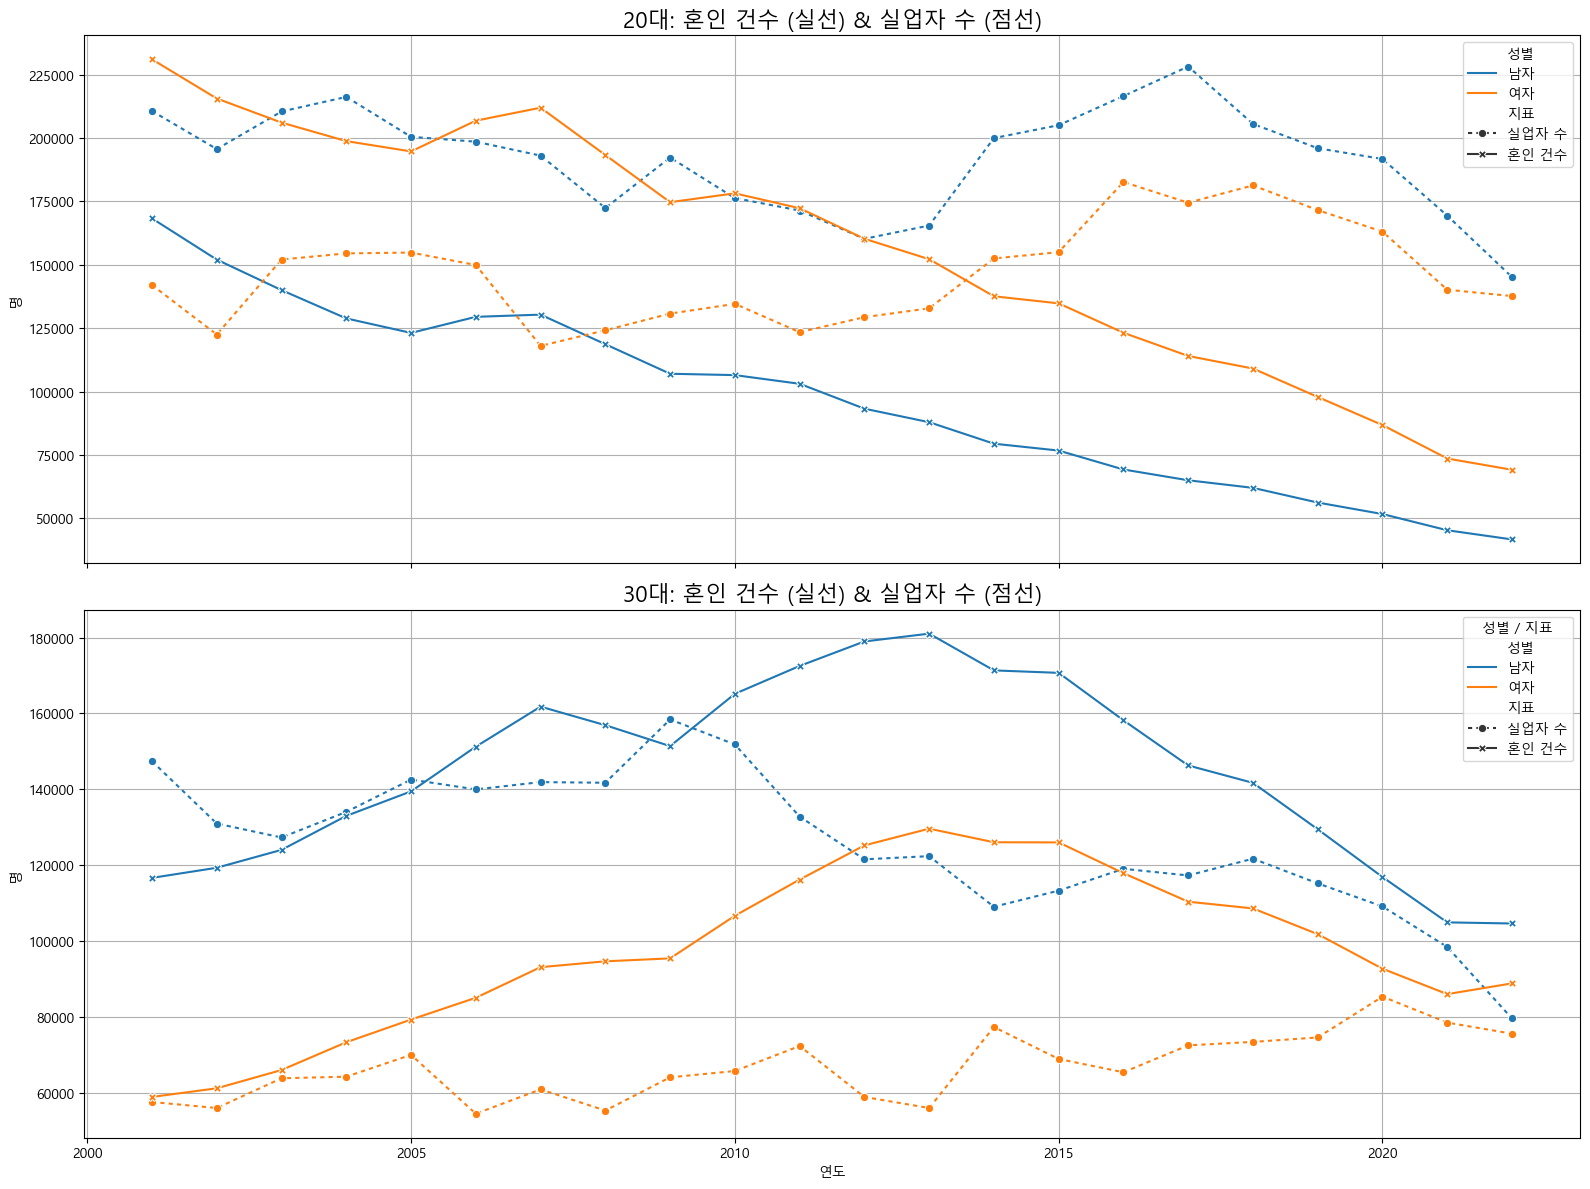

In [164]:
final_df.set_index("연도", inplace=True)

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='c:/windows/Fonts/malgun.ttf').get_name()
rc('font',family = font_name)

# 1. 20대 데이터와 30대 데이터를 각각 필터링
df_20 = final_df[final_df['연령대'] == '20대']
df_30 = final_df[final_df['연령대'] == '30대']

# 2. 한 화면에 2개의 서브플롯(그래프) 그리기
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 12), sharex=True)

# 3. 20대 그래프
# - 혼인 건수: 실선 (solid)
# - 실업자 수: 점선 (dotted)
sns.lineplot(
    data=df_20,
    x='연도', y='값',
    hue='성별', 
    style='지표', 
    markers=True,
    # dashes 설정: 혼인 건수 → 실선, 실업자 수 → 점선
    dashes={'혼인 건수': '', '실업자 수': (2,2)},
    ax=axes[0]
)
axes[0].set_title("20대: 혼인 건수 (실선) & 실업자 수 (점선)", fontsize=16)
axes[0].set_ylabel("명")
axes[0].grid(True)

# 4. 30대 그래프
sns.lineplot(
    data=df_30,
    x='연도', y='값',
    hue='성별', 
    style='지표', 
    markers=True,
    dashes={'혼인 건수': '', '실업자 수': (2,2)},
    ax=axes[1]
)
axes[1].set_title("30대: 혼인 건수 (실선) & 실업자 수 (점선)", fontsize=16)
axes[1].set_xlabel("연도")
axes[1].set_ylabel("명")
axes[1].grid(True)

# 5. 범례 설정
# 각 그래프에 대해 범례가 같이 나타나지만, 여기서는 30대 그래프의 범례를 사용합니다.
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles, labels, title="성별 / 지표", loc='upper right')

save_path = r"C:\Users\smhrd\Desktop\새 폴더\FlaskWeb\static\img\graph\가설4-20~30대 결혼 건수VS실업자 수.png"
plt.savefig(save_path, dpi=300)  # 해상도 300 DPI로 저장

plt.tight_layout()
plt.show()


C:\Users\smhrd\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
C:\Users\smhrd\AppData\Local\Temp\ipykernel_9388\3573806652.py:34: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  plt.savefig(save_path, dpi=300)  # 해상도 300 DPI로 저장
C:\Users\smhrd\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


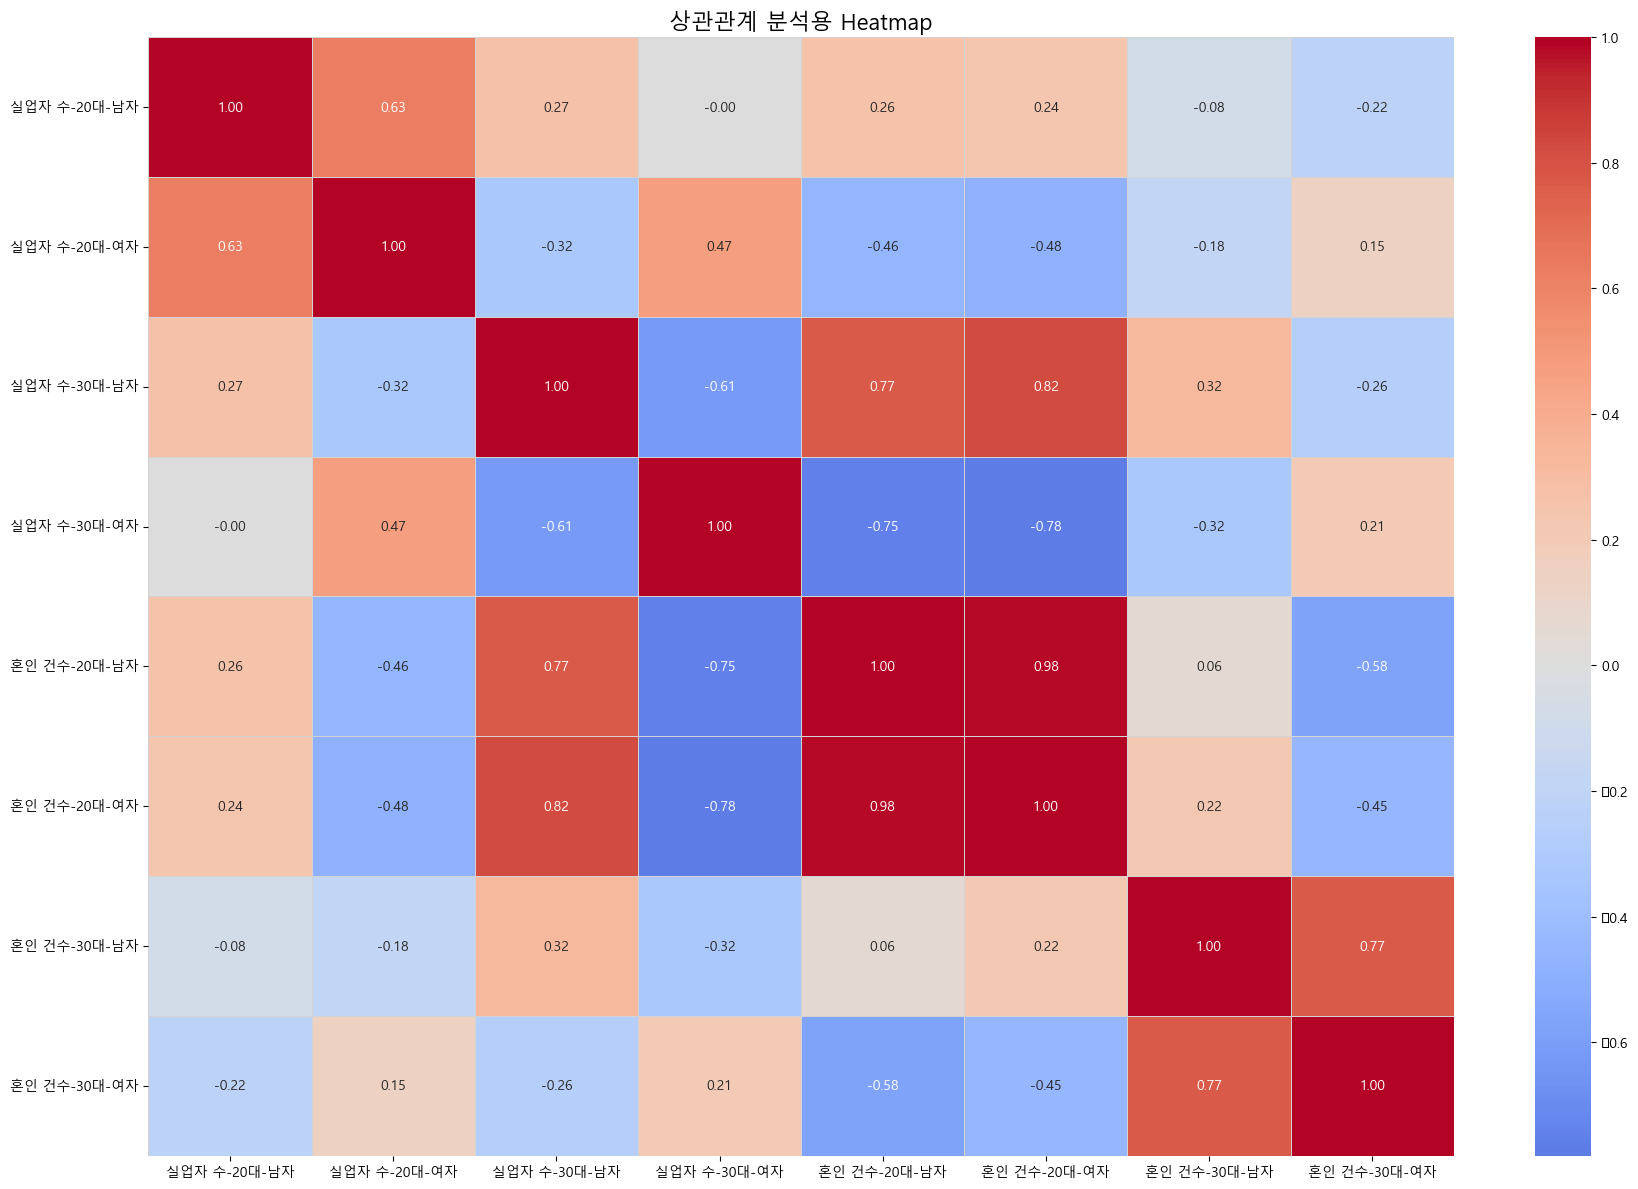

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 피벗: 연도별 각 집단의 시계열 (집단 = "지표-연령대-성별")
#    - aggfunc는 'mean' (연도별 해당 집단의 평균값; 경우에 따라 'sum'도 사용 가능)
pivot_data = final_df.pivot_table(
    index='연도',
    columns=['지표', '연령대', '성별'],
    values='값',
    aggfunc='mean'
)

# 2. 다중 인덱스 컬럼을 한 줄 문자열로 변환
pivot_data.columns = [f"{col[0]}-{col[1]}-{col[2]}" for col in pivot_data.columns]

# 3. 상관계수 행렬 계산
corr_matrix = pivot_data.corr()

# 4. 상관관계 Heatmap 그리기
plt.figure(figsize=(18, 12))
sns.heatmap(
    corr_matrix,
    annot=True,         # 각 셀에 상관계수 수치 표시
    fmt=".2f",
    cmap="coolwarm",    # 색상 팔레트 (중심=0)
    center=0,
    linewidths=0.5,
    linecolor='lightgray'
)

save_path = r"C:\Users\smhrd\Desktop\새 폴더\FlaskWeb\static\img\graph\가설4-20~30대 결혼 건수VS실업자 수 상관관계Heatmap.png"
plt.savefig(save_path, dpi=300)  # 해상도 300 DPI로 저장
plt.title("상관관계 분석용 Heatmap", fontsize=16)
plt.tight_layout()
plt.show()


# 결론

>### 20대
>- 혼인 건수 : 남녀 모두 2001년 이후 지속적 하락.
>- 실업자 수 : 일시적 상승 구간이 있었으나, 혼인 건수와 상관된 변화는 보이지 않음.
>- 상관관계를 분석했을 때에도 남,녀 모두 0.26, -0.48로 두 변수 간 직접 인과관계 약함.

>### 30대
>- 혼인 건수 2010년 전후로 정점 이후 전반적 하락.
>- 실업자 수 : 남녀 모두 변동성이 크며 패턴이 일정하지 않음.
>- 남성의 경우 2010~2015년 실업자 수가 하락하고 혼인건수가 증가하는 패턴이 있지만, 상관관계 분석 결과 0.32, 0.21로 직접적인 인과관계는 약함.


>#### 남성이 여성에 비해서 상관관계가 비교적 높음.
>#### 20대의 혼인 건수의 지속적인 하락, 30대의 2013년 정점 이후 급하락은 실업률 변화와는 독립적으로 나타나는 경향이 있어, 혼인율 저하에 영향을 미치는 다양한 비경제적 요인들을 고려할 필요가 있다.


# 추가
>- 비율이 아닌 혼인 건수, 실업자 수로 조사하여 조사에 신뢰도가 낮아졌을 것으로 예상.
   >- 20,30대의 인구수 데이터, 남녀 성비 데이터를 통해서 20,30대의 남녀 인구수를 추가하여 혼인률, 실업률을 계산

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# ===== 0. 한글 깨짐 방지=====
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='c:/windows/Fonts/malgun.ttf').get_name()
rc('font',family = font_name)

# ===== 1. 인구 데이터 (pop_by_age_sex) 생성 =====
# 인구수 - Sheet0.csv 파일은 아래 경로에 위치합니다.
csv_path = "./data/인구수 - Sheet0.csv"
pop_df = pd.read_csv(csv_path)

# CSV 파일은 다음과 같은 구조를 가집니다:
# 행 0: 전체 인구, 행 1: 남자, 행 2: 여자, 행 5: 20-29세, 행 6: 30-39세, 
# 열: 2001, 2002, ... 2022

# 열 이름(연도)을 숫자로 변환: 2001년부터 시작되는 열만 사용
years = [int(col) for col in pop_df.columns[2:]]

# 전체 인구, 남자, 여자 (각각 천 명 단위)
total_pop = pop_df.iloc[0, 2:].replace(",", "", regex=True).astype(int).values
male_pop = pop_df.iloc[1, 2:].replace(",", "", regex=True).astype(int).values
female_pop = pop_df.iloc[2, 2:].replace(",", "", regex=True).astype(int).values

# 20-29세 (행 5)와 30-39세 (행 6); 단위: 천 명
pop_20s = pop_df.iloc[5, 2:].replace(",", "", regex=True).astype(int).values
pop_30s = pop_df.iloc[6, 2:].replace(",", "", regex=True).astype(int).values

# 남녀 비율 (전체 인구 대비)
male_ratio = male_pop / total_pop
female_ratio = female_pop / total_pop

# 추정: 각 연령대 남녀 인구 (단위: 천 명)
pop_20s_male = (pop_20s * male_ratio).round().astype(int)
pop_20s_female = (pop_20s * female_ratio).round().astype(int)
pop_30s_male = (pop_30s * male_ratio).round().astype(int)
pop_30s_female = (pop_30s * female_ratio).round().astype(int)

# 최종 인구 DataFrame: 각 행의 단위는 '천 명'
pop_by_age_sex = pd.DataFrame({
    '연도': years,
    '20대 남자 인구': pop_20s_male,
    '20대 여자 인구': pop_20s_female,
    '30대 남자 인구': pop_30s_male,
    '30대 여자 인구': pop_30s_female
})

# 결과 확인 (pop_by_age_sex가 잘 생성되었는지)
print(pop_by_age_sex.head())

# ===== 2. 혼인 건수 및 실업자 수 데이터를 이용한 혼인율, 실업률 계산 =====
# final_df는 [연도, 연령대, 성별, 값, 지표] 형태이며, 지표는 "혼인 건수" 또는 "실업자 수"입니다.
# 단, final_df의 '값'은 이미 명 단위로 처리되었다고 가정합니다.

# 예시로, final_df가 아래와 같이 구성되어 있어야 합니다:
#    연도   연령대   성별      값       지표
# 0  2001   20대   남자   210700   실업자 수
# 1  2001   20대   여자   142000   실업자 수
# 2  2001   30대   남자   147417   실업자 수
# 3  2001   30대   여자    57667   실업자 수
# 4  2001   20대   남자   168305   혼인 건수
# ...

# 분리: 혼인 건수와 실업자 수 데이터
df_marriage = final_df[final_df['지표'] == '혼인 건수'].copy()
df_unemp = final_df[final_df['지표'] == '실업자 수'].copy()

df_marriage.rename(columns={'값': '혼인건수'}, inplace=True)
df_unemp.rename(columns={'값': '실업자수'}, inplace=True)

# ===== 3. 인구 데이터(pop_by_age_sex)를 long 포맷으로 변환 =====
# pop_by_age_sex의 열 이름은 "20대 남자 인구", "20대 여자 인구", 등
pop_long = pop_by_age_sex.melt(id_vars='연도', var_name='group', value_name='인구')
# group 예시: "20대 남자 인구" → 연령대: "20대", 성별: "남자"
pop_long['연령대'] = pop_long['group'].str.split().str[0]  
pop_long['성별'] = pop_long['group'].str.split().str[1]      
pop_long = pop_long[['연도', '연령대', '성별', '인구']]

# 만약 final_df의 혼인건수, 실업자수의 단위가 "명"이라면, 인구수는 현재 "천 명"이므로 1000을 곱해 단위를 맞춰야 합니다.
# 아래 주석 해제 후 사용하세요:
pop_long['인구'] = pop_long['인구'] * 1000

# ===== 4. 혼인, 실업 데이터와 인구 데이터 병합 후 비율 계산 =====
df_marriage = pd.merge(df_marriage, pop_long, on=['연도', '연령대', '성별'], how='left')
df_unemp = pd.merge(df_unemp, pop_long, on=['연도', '연령대', '성별'], how='left')

# 혼인율 (%) = (혼인건수 / 인구) * 100, 실업률 (%) = (실업자수 / 인구) * 100
df_marriage['혼인율'] = (df_marriage['혼인건수'] / df_marriage['인구']) * 100
df_unemp['실업률'] = (df_unemp['실업자수'] / df_unemp['인구']) * 100

# ===== 5. 남녀별 혼인율 및 실업률을 결합하여 최종 비율 데이터 =====
df_rates = pd.merge(
    df_marriage[['연도', '연령대', '성별', '혼인율']],
    df_unemp[['연도', '연령대', '성별', '실업률']],
    on=['연도', '연령대', '성별'],
    how='outer'
)
# df_rates의 구조: 연도, 연령대, 성별, 혼인율, 실업률





     연도  20대 남자 인구  20대 여자 인구  30대 남자 인구  30대 여자 인구
0  2001       4108       4050       4311       4250
1  2002       4067       4009       4335       4274
2  2003       4023       3964       4346       4282
3  2004       3940       3884       4364       4303
4  2005       3840       3793       4341       4287


C:\Users\smhrd\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
C:\Users\smhrd\AppData\Local\Temp\ipykernel_9388\3902723281.py:14: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  plt.savefig(save_path, dpi=300)  # 해상도 300 DPI로 저장
C:\Users\smhrd\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


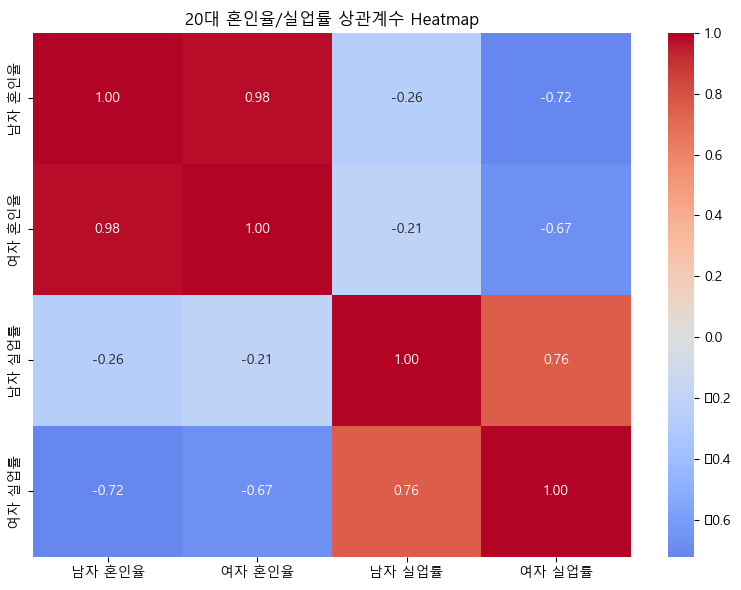

In [189]:
# ===== 6. 상관관계 분석용 히트맵 (연령대별) =====
# 6-1. 20대 데이터 피벗 (행: 연도, 열: 성별별 지표)
df_20 = df_rates[df_rates['연령대'] == '20대'].copy()
df_20_pivot = df_20.pivot(index='연도', columns='성별', values=['혼인율', '실업률'])
df_20_pivot.columns = [f"{col[1]} {col[0]}" for col in df_20_pivot.columns]
corr_20 = df_20_pivot.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_20, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("20대 혼인율/실업률 상관계수 Heatmap")
plt.tight_layout()

save_path = r"C:\Users\smhrd\Desktop\새 폴더\FlaskWeb\static\img\graph\가설4-20대 결혼율VS실업율 상관관계Heatmap.png"
plt.savefig(save_path, dpi=300)  # 해상도 300 DPI로 저장

plt.show()



C:\Users\smhrd\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
C:\Users\smhrd\AppData\Local\Temp\ipykernel_9388\3380903266.py:13: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  plt.savefig(save_path, dpi=300)  # 해상도 300 DPI로 저장
C:\Users\smhrd\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


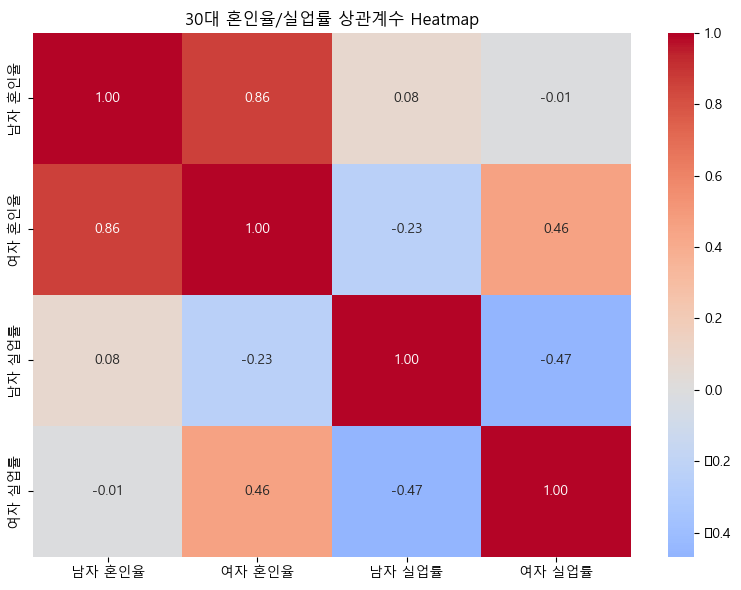

In [191]:
# 6-2. 30대 데이터 피벗
df_30 = df_rates[df_rates['연령대'] == '30대'].copy()
df_30_pivot = df_30.pivot(index='연도', columns='성별', values=['혼인율', '실업률'])
df_30_pivot.columns = [f"{col[1]} {col[0]}" for col in df_30_pivot.columns]
corr_30 = df_30_pivot.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_30, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("30대 혼인율/실업률 상관계수 Heatmap")
plt.tight_layout()

save_path = r"C:\Users\smhrd\Desktop\새 폴더\FlaskWeb\static\img\graph\가설4-30대 결혼율VS실업율 상관관계Heatmap.png"
plt.savefig(save_path, dpi=300)  # 해상도 300 DPI로 저장

plt.show()



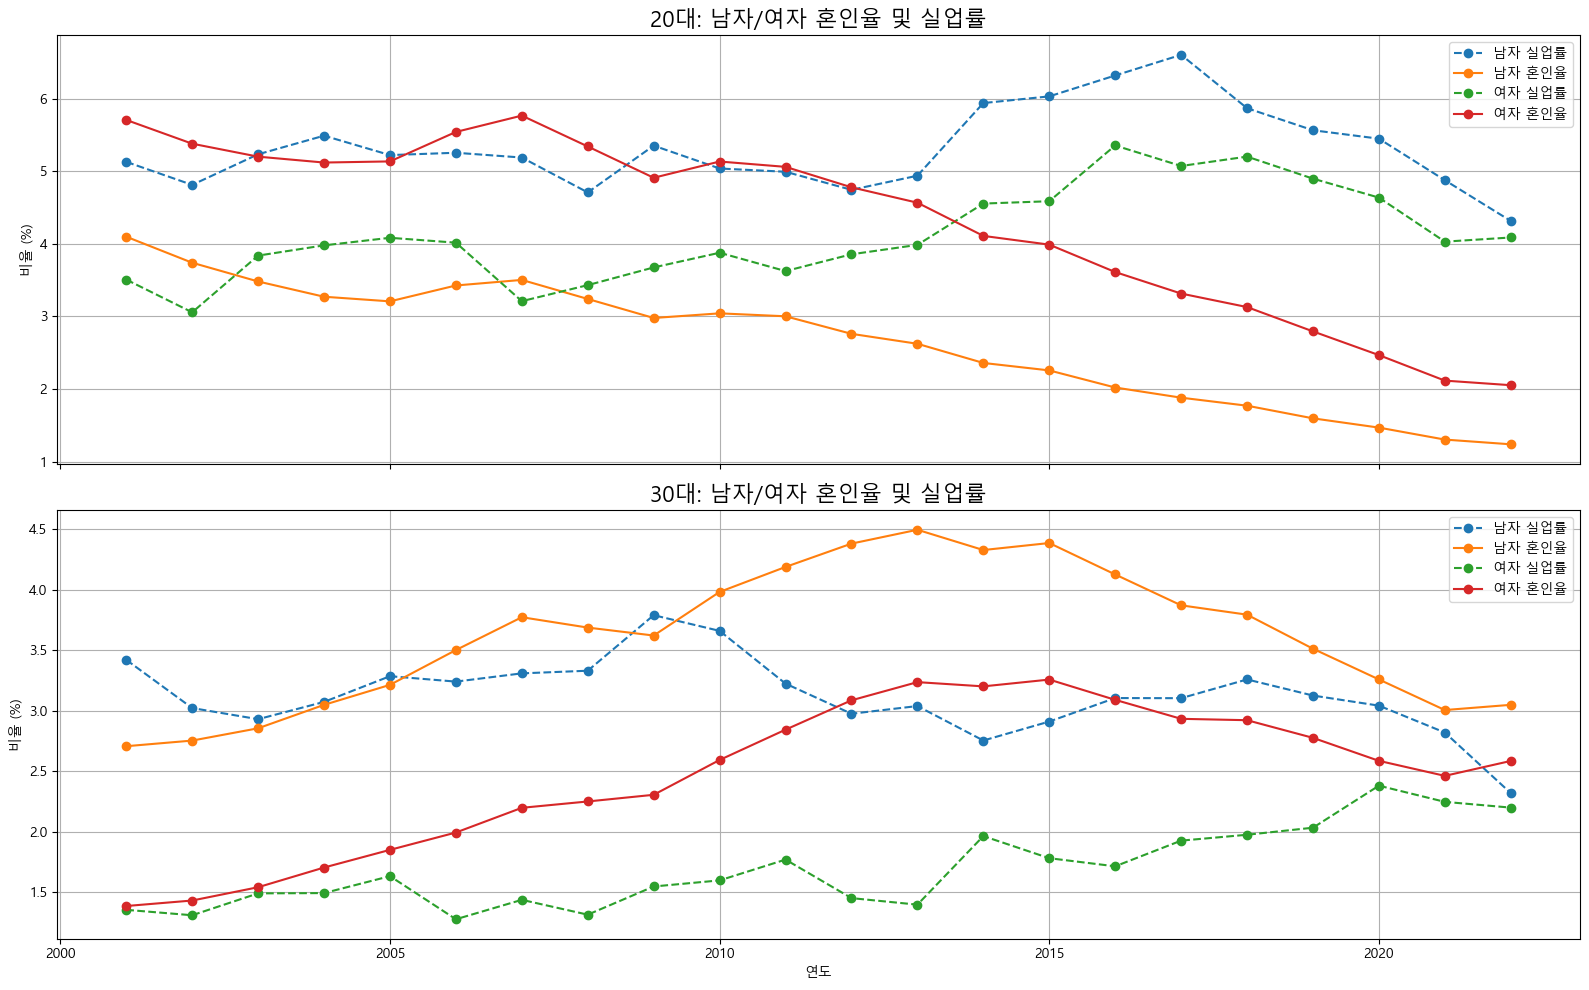

In [193]:
# ===== 7. 시계열 그래프 그리기 (연령대별: 20대와 30대 별로 2개 그래프) =====
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 10), sharex=True)

# 7-1. 20대 그래프: 남자와 여자의 혼인율 및 실업률
for gender in ['남자', '여자']:
    sub_df = df_20[df_20['성별'] == gender]
    axes[0].plot(sub_df['연도'], sub_df['실업률'], marker='o', linestyle='--', label=f"{gender} 실업률")
    axes[0].plot(sub_df['연도'], sub_df['혼인율'], marker='o', linestyle='-', label=f"{gender} 혼인율")
axes[0].set_title("20대: 남자/여자 혼인율 및 실업률", fontsize=16)
axes[0].set_ylabel("비율 (%)")
axes[0].grid(True)
axes[0].legend(loc='upper right')

# 7-2. 30대 그래프: 남자와 여자의 혼인율 및 실업률
for gender in ['남자', '여자']:
    sub_df = df_30[df_30['성별'] == gender]
    axes[1].plot(sub_df['연도'], sub_df['실업률'], marker='o', linestyle='--', label=f"{gender} 실업률")
    axes[1].plot(sub_df['연도'], sub_df['혼인율'], marker='o', linestyle='-', label=f"{gender} 혼인율")
axes[1].set_title("30대: 남자/여자 혼인율 및 실업률", fontsize=16)
axes[1].set_xlabel("연도")
axes[1].set_ylabel("비율 (%)")
axes[1].grid(True)
axes[1].legend(loc='upper right')


plt.tight_layout()

save_path = r"C:\Users\smhrd\Desktop\새 폴더\FlaskWeb\static\img\graph\가설4-20~30대 혼인율VS실업률.png"
plt.savefig(save_path, dpi=300)  # 해상도 300 DPI로 저장

plt.show()

># 결과분석
> 20대 여자의 실업률과 20대 남녀 혼인율에 모두 유의미한 상관관계가 있는 것 같음.
>- 하지만 그래프 분석 결과 단순 실업률과 혼인율은 유의미한 관계가 관촬되지 않음.

>### 결론적으로 혼인율의 감소 추세는 단순 실업률 변화 하나의 원인으로는 설명할 수 없다. 